# DATA LOAD, PIPELINE SET UP, AND CONFIGURATION

In [ ]:
# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
!pip install -q segmentation_models_pytorch timm optuna

import torch
import numpy as np
import random
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2 
import segmentation_models_pytorch as smp
from sklearn.model_selection import StratifiedKFold
from sklearn.isotonic import IsotonicRegression
import torch.amp
import optuna

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

set_seed(42)

CONFIG = {
    "TRAIN_IMG_DIR": "/kaggle/input/competitions/data-science-ara-7-0/dataset/dataset/train/images",
    "TRAIN_MASK_DIR": "/kaggle/input/competitions/data-science-ara-7-0/dataset/dataset/train/mask",
    "TEST_IMG_DIR": "/kaggle/input/competitions/data-science-ara-7-0/dataset/dataset/test/images",
    "IMG_SIZE": 512,
    "BATCH_SIZE": 8,
    "LEARNING_RATE": 1e-4,
    "LEARNING_RATE_MANET": 2e-5,
    "EPOCHS_MANET": 20,
    "EPOCHS": 20,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "N_FOLDS": 5
}



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

> Setup ini dirancang untuk menjamin reprodusibilitas total agar hasil eksperimen valid dan tidak bergantung pada faktor "keberuntungan". Instalasi segmentation_models_pytorch memudahkan akses ke arsitektur SOTA (State-of-the-Art), sementara fungsi set_seed(42) secara agresif mengunci seluruh sumber variabilitas acak di Python, NumPy, dan PyTorch. Secara khusus, konfigurasi cudnn.deterministic = True dan cudnn.benchmark = False dipilih untuk memaksa GPU menggunakan algoritma konvolusi yang konsisten, sehingga setiap kali menjalankan ulang kode, hasilnya akan sama persis, memungkinkan untuk re-evaluasi dampak perubahan hyperparameter dengan akurat tanpa bias inisialisasi.

> Selain itu, kode ini berfungsi sebagai fondasi pipeline yang mengintegrasikan library standar industri (segmentation_models_pytorch dan albumentations) untuk mempermudah akses ke arsitektur model State-of-the-Art dan augmentasi gambar yang cepat. Konfigurasi CONFIG dipusatkan dalam satu dictionary agar eksperimen hyperparameter menjadi konsisten dan mudah diatur. Pemilihan IMG_SIZE 512 adalah strategi agresif untuk menangkap detail kecil pada lubang jalan (potholes), yang dikompensasi dengan BATCH_SIZE 8 agar tetap aman dari Out of Memory (OOM) pada VRAM GPU, menyeimbangkan antara resolusi tinggi dan stabilitas training.

# EXPLORATORY DATA ANALYSIS

🔍 Sedang memeriksa dataset di: /kaggle/input/competitions/data-science-ara-7-0/dataset/dataset/train/mask
📂 Ditemukan 498 mask. Memulai scanning...


  0%|          | 0/498 [00:00<?, ?it/s]


📊 HASIL ANALISIS DATASET
Total File Mask      : 498
Total Pixels         : 1,413,124,671
Pothole Pixels (1)   : 118,588,901 (8.39%)
Background Pixels (0): 1,294,535,770 (91.61%)
Total Objek Lubang   : 2122

💡 REKOMENDASI:
✅  Imbalance masih wajar. Standard Dice Loss aman digunakan.


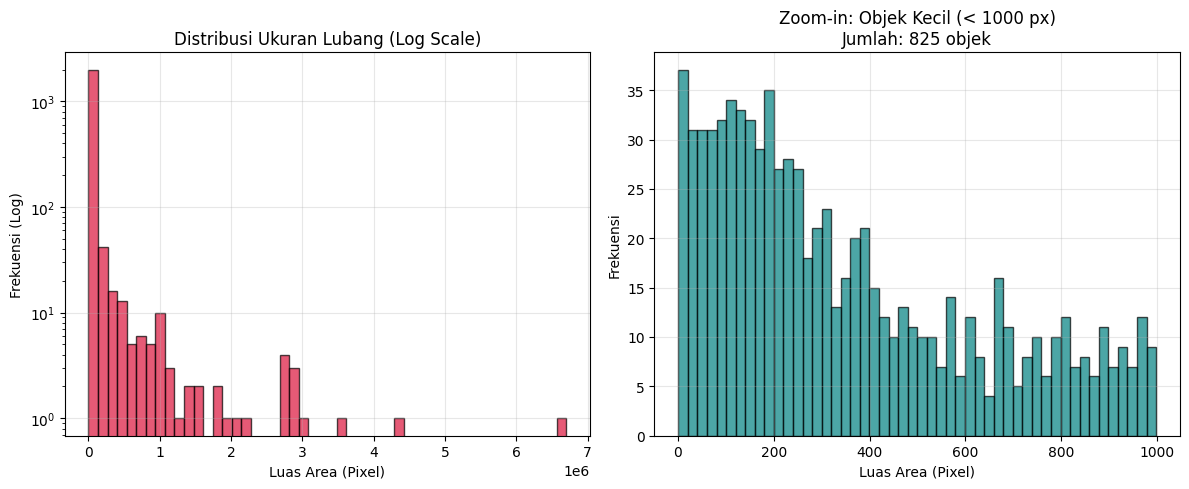

In [ ]:
# ==========================================
# 2. DATA ANALYSIS (EDA) & CLASS IMBALANCE CHECK
# ==========================================
import glob
from tqdm.auto import tqdm  # Progress bar agar tidak bosan menunggu

def check_class_imbalance(mask_dir):
    print(f"🔍 Sedang memeriksa dataset di: {mask_dir}")
    
    # Ambil semua file mask (mencoba berbagai ekstensi umum)
    mask_files = glob.glob(os.path.join(mask_dir, "*"))
    # Filter hanya file gambar jika folder kotor
    valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG')
    mask_files = [f for f in mask_files if f.endswith(valid_exts)]
    
    if len(mask_files) == 0:
        print("❌ Error: Tidak ada file mask ditemukan! Cek path direktori.")
        return []

    total_pixels = 0
    pothole_pixels = 0
    pothole_areas = [] # Untuk menyimpan ukuran setiap lubang
    
    print(f"Ditemukan {len(mask_files)} mask. Memulai scanning...")
    
    for mask_path in tqdm(mask_files):
        # Baca mask sebagai Grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            continue
            
        # Binarisasi (Pastikan 0 dan 1)
        # Asumsi: Putih (>127) adalah lubang
        mask = (mask > 127).astype(np.uint8)
        
        # 1. Hitung total pixel putih vs hitam
        total_pixels += mask.size
        pothole_pixels += mask.sum()
        
        # 2. Hitung area per objek (blob) untuk histogram
        # connectedComponents menghitung jumlah "pulau" putih terpisah
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        
        # Label 0 adalah background, mulai loop dari 1
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            pothole_areas.append(area)

    # Hitung Rasio
    if total_pixels == 0:
        print("Total pixel 0. Sesuatu yang salah terjadi.")
        return []

    pothole_ratio = (pothole_pixels / total_pixels) * 100
    background_ratio = 100 - pothole_ratio
    
    print("\n" + "="*40)
    print(f"📊 HASIL ANALISIS DATASET")
    print("="*40)
    print(f"Total File Mask      : {len(mask_files)}")
    print(f"Total Pixels         : {total_pixels:,}")
    print(f"Pothole Pixels (1)   : {pothole_pixels:,} ({pothole_ratio:.2f}%)")
    print(f"Background Pixels (0): {total_pixels - pothole_pixels:,} ({background_ratio:.2f}%)")
    print(f"Total Objek Lubang   : {len(pothole_areas)}")
    print("="*40)
    
    # Rekomendasi Otomatis
    print("\n💡 REKOMENDASI:")
    if pothole_ratio < 5.0:
        print("⚠️  EXTREME IMBALANCE (< 5%) terdeteksi!")
        print("   -> WAJIB menggunakan 'Focal Loss' atau 'Combo Loss'.")
        print("   -> 'Dice Loss' saja mungkin tidak cukup.")
    else:
        print("✅  Imbalance masih wajar. Standard Dice Loss aman digunakan.")
        
    return pothole_areas

# Jalankan Fungsi
pothole_areas = check_class_imbalance(CONFIG['TRAIN_MASK_DIR'])

# Plot Histogram Ukuran Lubang
if len(pothole_areas) > 0:
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Log Scale (untuk melihat distribusi keseluruhan termasuk yang kecil)
    plt.subplot(1, 2, 1)
    plt.hist(pothole_areas, bins=50, log=True, color='crimson', alpha=0.7, edgecolor='black')
    plt.title("Distribusi Ukuran Lubang (Log Scale)")
    plt.xlabel("Luas Area (Pixel)")
    plt.ylabel("Frekuensi (Log)")
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Zoom in ke objek kecil (misal < 1000 pixel)
    small_objects = [area for area in pothole_areas if area < 1000]
    plt.subplot(1, 2, 2)
    plt.hist(small_objects, bins=50, color='teal', alpha=0.7, edgecolor='black')
    plt.title(f"Zoom-in: Objek Kecil (< 1000 px)\nJumlah: {len(small_objects)} objek")
    plt.xlabel("Luas Area (Pixel)")
    plt.ylabel("Frekuensi")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

> Berdasarkan hasil analisis dan hasil visualisasi, keduanya mengungkapkan dua karakteristik kritis pada dataset, yaitu ketimpangan kelas yang ekstrem di mana piksel pothole menempati proporsi yang sangat kecil (8.39%) dibandingkan latar belakang (91.61%), serta variasi skala objek yang signifikan yang ditunjukkan oleh distribusi long-tail pada histogram ukuran lubang. Temuan ini menjadi landasan rasional yang kuat bagi desain pipeline training.Konsep segmentasi berbasis metrik evaluasi DICE menguatkan penggunaan Dice loss untuk mengoptimalkan overlap spasial yang tidak terpengaruh oleh jumlah piksel latar belakang. Selanjutnya, variasi ukuran lubang, mulai dari retakan halus hingga lubang besar, menjadi alasan utama penerapan strategi Ensemble Heterogen.

📊 DETAIL STATISTIK UKURAN LUBANG
count    2.122000e+03
mean     5.588544e+04
std      3.030841e+05
min      1.000000e+00
25%      3.930000e+02
50%      1.913000e+03
75%      1.203275e+04
max      6.700584e+06
Name: Area (Pixels), dtype: float64
----------------------------------------
🔹 Lubang Kecil (< 32x32 px)   : 837 (39.4%)
🔹 Lubang Sedang               : 703 (33.1%)
🔹 Lubang Besar (> 100x100 px) : 582 (27.4%)


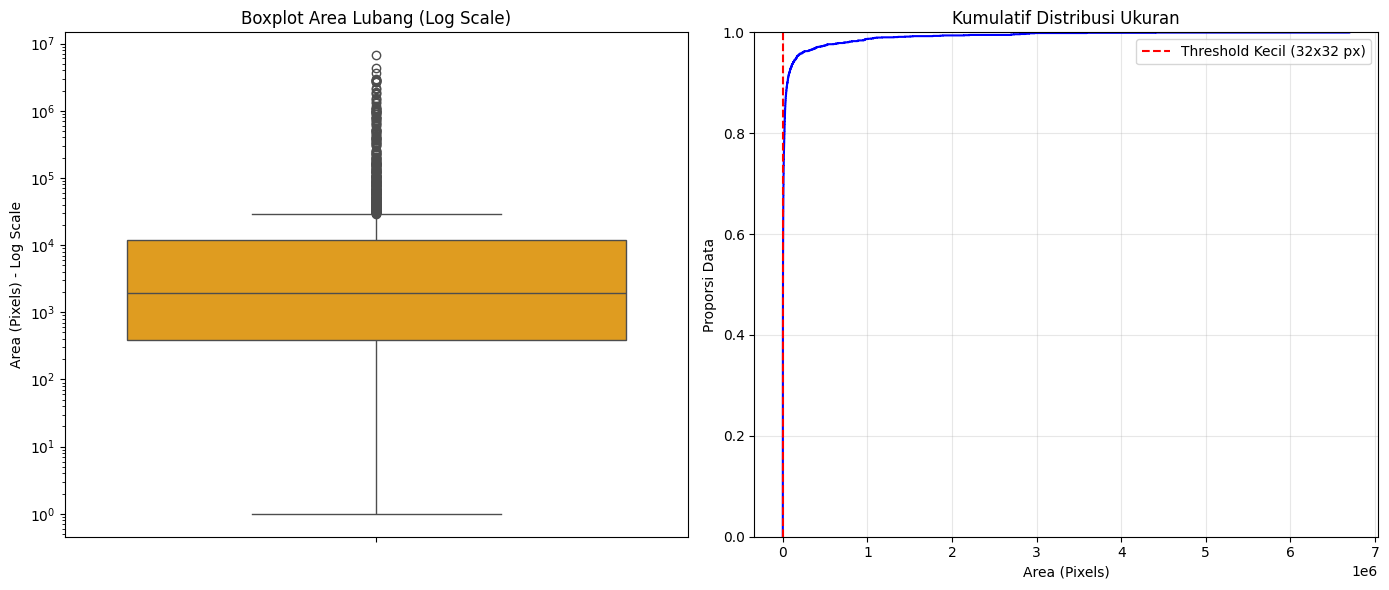


💡 KESIMPULAN STRATEGI:
⚠️  BANYAK LUBANG KECIL! (>30%)
   Rekomendasi:
   1. JANGAN gunakan Resize drastis (misal ke 256x256).
   2. Gunakan Input Size 512x512 atau lebih besar.
   3. Pertimbangkan metode 'Tiling' (potong gambar jadi 4 bagian).
   4. Pastikan arsitektur model punya skip-connection kuat (U-Net++ atau DeepLabV3+).


In [5]:
# ==========================================
# 3. ANALISIS MENDALAM UKURAN LUBANG
# ==========================================
import seaborn as sns

# Pastikan variable 'pothole_areas' sudah ada. 
# Jika error, jalankan dulu cell 'check_class_imbalance' di atas.
if 'pothole_areas' in locals() and len(pothole_areas) > 0:
    
    # Konversi ke Pandas Series agar mudah dihitung
    df_area = pd.Series(pothole_areas, name="Area (Pixels)")
    
    # 1. Statistik Deskriptif
    print("📊 DETAIL STATISTIK UKURAN LUBANG")
    print("="*40)
    stats = df_area.describe()
    print(stats)
    print("-" * 40)
    
    # 2. Kategorisasi Ukuran (Berdasarkan resolusi 512x512)
    # Kecil  : < 1024 px (kira-kira blok 32x32)
    # Sedang : 1024 - 10,000 px (kira-kira blok 100x100)
    # Besar  : > 10,000 px
    
    n_small = (df_area < 1024).sum()
    n_med   = ((df_area >= 1024) & (df_area < 10000)).sum()
    n_large = (df_area >= 10000).sum()
    
    print(f"🔹 Lubang Kecil (< 32x32 px)   : {n_small} ({n_small/len(df_area)*100:.1f}%)")
    print(f"🔹 Lubang Sedang               : {n_med} ({n_med/len(df_area)*100:.1f}%)")
    print(f"🔹 Lubang Besar (> 100x100 px) : {n_large} ({n_large/len(df_area)*100:.1f}%)")
    print("="*40)

    # 3. Visualisasi
    plt.figure(figsize=(14, 6))

    # Plot A: Boxplot (Untuk melihat outlier/lubang raksasa)
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_area, color='orange')
    plt.yscale('log') # Pakai skala log agar yang kecil dan besar terlihat semua
    plt.title("Boxplot Area Lubang (Log Scale)")
    plt.ylabel("Area (Pixels) - Log Scale")

    # Plot B: Cumulative Distribution (CDF)
    # Untuk menjawab: "Berapa persen lubang yang ukurannya di bawah X?"
    plt.subplot(1, 2, 2)
    sns.ecdfplot(data=df_area, color='blue')
    plt.axvline(1024, color='red', linestyle='--', label='Threshold Kecil (32x32 px)')
    plt.title("Kumulatif Distribusi Ukuran")
    plt.xlabel("Area (Pixels)")
    plt.ylabel("Proporsi Data")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # --- KESIMPULAN OTOMATIS ---
    print("\n💡 KESIMPULAN STRATEGI:")
    if n_small / len(df_area) > 0.3: # Jika lebih dari 30% adalah lubang kecil
        print("⚠️  BANYAK LUBANG KECIL! (>30%)")
        print("   Rekomendasi:")
        print("   1. JANGAN gunakan Resize drastis (misal ke 256x256).")
        print("   2. Gunakan Input Size 512x512 atau lebih besar.")
        print("   3. Pertimbangkan metode 'Tiling' (potong gambar jadi 4 bagian).")
        print("   4. Pastikan arsitektur model punya skip-connection kuat (U-Net++ atau DeepLabV3+).")
    else:
        print("✅  Mayoritas lubang berukuran sedang/besar.")
        print("   Metode Resize biasa (512x512) aman digunakan.")
        
else:
    print("⚠️ Variable 'pothole_areas' tidak ditemukan.")
    print("Silakan jalankan kode 'check_class_imbalance' sebelumnya terlebih dahulu.")

> Data menunjukkan bahwa mayoritas objek lubang berada pada kategori kecil (lebih  kecil dari 32 x 32 px) sebanyak 39.4%. Namun, terdapat rentang ukuran yang luar biasa lebar, mulai dari hanya 1 pixel hingga 6,7 juta pixel. Perbedaan antara median (1.913 px) dan mean (55.885 px) yang terpaut jauh, ditambah dengan banyaknya outliers pada Boxplot Log Scale, mengonfirmasi adanya ketimpangan ukuran yang masif. Pada grafik Kumulatif Distribusi, terlihat kurva menanjak sangat tajam di awal, mengindikasikan bahwa sebagian besar populasi data adalah lubang berukuran kecil yang sangat sulit dideteksi karena keterbatasan resolusi fitur.

🔍 Memeriksa resolusi gambar di: /kaggle/input/competitions/data-science-ara-7-0/dataset/dataset/train/images
📂 Memproses 498 gambar...


  0%|          | 0/498 [00:00<?, ?it/s]


📊 STATISTIK RESOLUSI
             Width       Height       Ratio
count   498.000000   498.000000  498.000000
mean   1237.628514  1127.676707    1.364943
std    1193.306616  1310.775697    0.400631
min     200.000000   129.000000    0.666926
25%     416.000000   300.000000    1.000000
50%     720.000000   525.000000    1.333333
75%    1278.000000   857.000000    1.686489
max    4080.000000  4608.000000    2.971429

🔹 Variasi Ukuran Gambar:
     Width  Height  Count
0      200     150      1
1      200     200      2
2      204     170      1
3      225     150      1
4      225     300      1
..     ...     ...    ...
177   3200    1680      1
178   3456    4608      1
179   3680    2760     39
180   4000    3000     11
181   4080    2296      1

[182 rows x 3 columns]


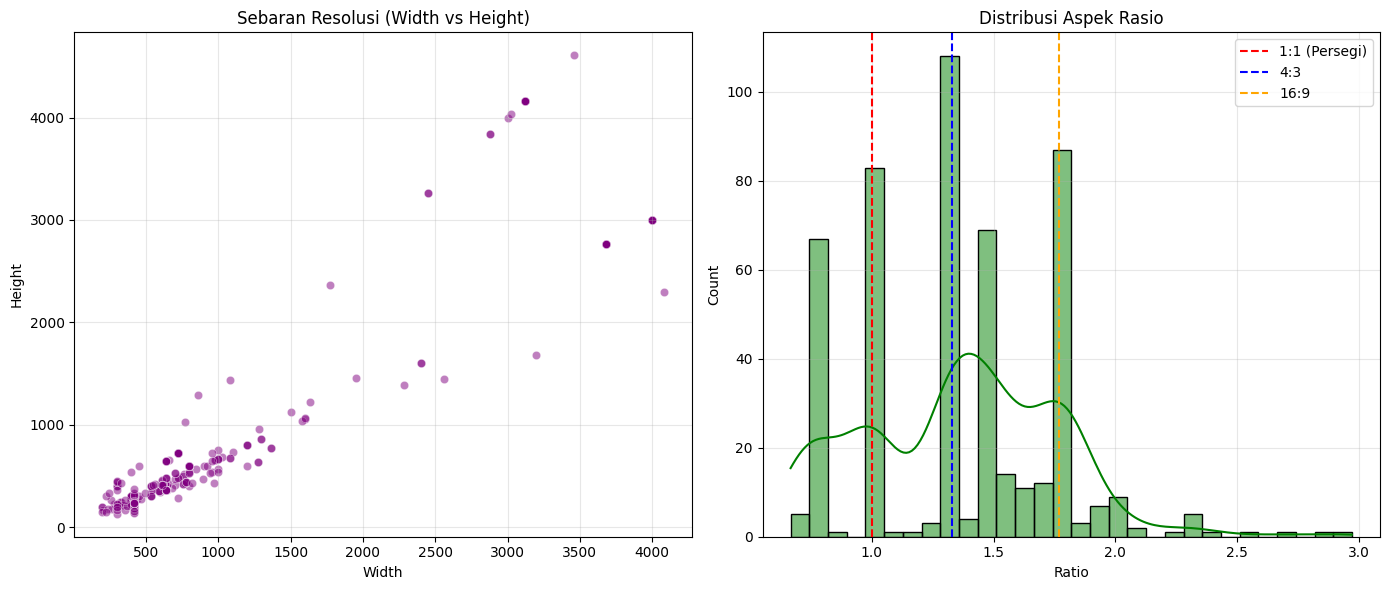


💡 REKOMENDASI STRATEGI:
⚠️  BERAGAM: Terdapat variasi rasio yang signifikan (Potrait & Landscape campur).
   -> JANGAN langsung Resize paksa, gambar akan gepeng!
   -> Solusi: Gunakan 'PadIfNeeded' (tambah border hitam) agar jadi persegi dulu,
      baru kemudian di-Resize ke 512x512.


In [8]:
# ==========================================
# 4. CEK RESOLUSI & ASPEK RASIO GAMBAR
# ==========================================
def check_resolution_and_ratio(img_dir):
    print(f"🔍 Memeriksa resolusi gambar di: {img_dir}")
    
    # Ambil semua file gambar
    img_files = glob.glob(os.path.join(img_dir, "*"))
    valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG')
    img_files = [f for f in img_files if f.endswith(valid_exts)]
    
    if len(img_files) == 0:
        print("❌ Error: Tidak ada gambar ditemukan.")
        return

    widths = []
    heights = []
    aspect_ratios = []
    
    print(f"📂 Memproses {len(img_files)} gambar...")
    
    for img_path in tqdm(img_files):
        # Kita baca header gambar saja agar cepat (tidak perlu load pixelnya)
        # Menggunakan PIL lebih cepat untuk sekedar cek ukuran daripada OpenCV
        from PIL import Image
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)

    # Buat DataFrame agar mudah dianalisis
    df_res = pd.DataFrame({
        'Width': widths, 
        'Height': heights, 
        'Ratio': aspect_ratios
    })
    
    # 1. Statistik Resolusi
    print("\n" + "="*40)
    print("📊 STATISTIK RESOLUSI")
    print("="*40)
    print(df_res.describe())
    
    # Cek apakah semua ukuran sama
    unique_sizes = df_res.groupby(['Width', 'Height']).size().reset_index(name='Count')
    print("\n🔹 Variasi Ukuran Gambar:")
    print(unique_sizes)
    
    # 2. Visualisasi Scatter Plot (Lebar vs Tinggi)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='Width', y='Height', alpha=0.5, color='purple')
    plt.title("Sebaran Resolusi (Width vs Height)")
    plt.grid(True, alpha=0.3)
    
    # 3. Visualisasi Histogram Aspek Rasio
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_res, x='Ratio', bins=30, kde=True, color='green')
    plt.axvline(1.0, color='red', linestyle='--', label='1:1 (Persegi)')
    plt.axvline(1.33, color='blue', linestyle='--', label='4:3')
    plt.axvline(1.77, color='orange', linestyle='--', label='16:9')
    plt.title("Distribusi Aspek Rasio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- REKOMENDASI ---
    print("\n💡 REKOMENDASI STRATEGI:")
    # Cek keragaman rasio
    std_ratio = df_res['Ratio'].std()
    
    if len(unique_sizes) == 1:
        print("✅  PERFECT: Semua gambar memiliki ukuran yang SAMA PERSIS.")
        print("   -> Dataset sangat rapi. Preprocessing sangat mudah.")
        
    elif std_ratio < 0.05:
        print("✅  Stabil: Ukuran gambar bervariasi tapi Rasio-nya mirip.")
        print("   -> Resize (squash) ke 512x512 aman dilakukan, distorsi minim.")
        
    else:
        print("⚠️  BERAGAM: Terdapat variasi rasio yang signifikan (Potrait & Landscape campur).")
        print("   -> JANGAN langsung Resize paksa, gambar akan gepeng!")
        print("   -> Solusi: Gunakan 'PadIfNeeded' (tambah border hitam) agar jadi persegi dulu,")
        print("      baru kemudian di-Resize ke 512x512.")

# Jalankan Fungsi
check_resolution_and_ratio(CONFIG['TRAIN_IMG_DIR'])

> Berdasarkan scatter plot "Sebaran Resolusi", terlihat adanya heterogenitas ekstrem pada dimensi citra input. Data menyebar dari resolusi yang sangat rendah (sekitar 300-400 piksel) hingga resolusi ultra-tinggi (di atas 4000 piksel). Ini mengindikasikan bahwa data pothole ini diambil dari berbagai perangkat akuisisi yang berbeda (seperti kamera ponsel low-end, dashcam, hingga kamera resolusi tinggi). Temuan ini diperkuat oleh histogram "Distribusi Aspek Rasio" yang menunjukkan adanya pola multimodal dengan puncak yang sangat jelas pada rasio sekitar 4:3 (tipikal kamera ponsel/digital standar) dan 16:9 (tipikal format video/HD dashcam), serta sedikit sebaran di rasio 1:1. Variasi ini menegaskan bahwa dataset ini bersifat tidak terstandarisasi.

☀️ Memulai analisis intensitas cahaya (Brightness)...
   -> Memproses folder Train...


Train:   0%|          | 0/498 [00:00<?, ?it/s]

   -> Memproses folder Test...


Test:   0%|          | 0/295 [00:00<?, ?it/s]


📊 STATISTIK KECERAHAN (0=Gelap, 255=Terang)
Metric     | Train      | Test       | Diff      
----------------------------------------------
Mean       | 134.04     | 136.49     | 2.45      
Std Dev    | 21.69      | 20.19      | 1.50      
Min        | 65.95      | 70.09      | -
Max        | 192.92     | 194.73     | -


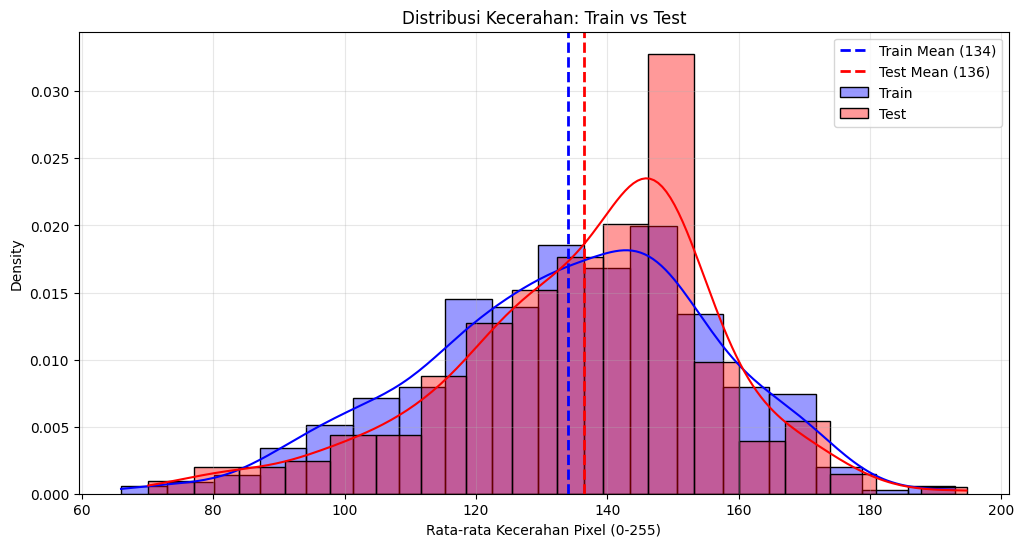


💡 REKOMENDASI AUGMENTASI:
✅  Sangat Mirip (< 10 point).
   -> Distribusi cahaya Train dan Test konsisten.
   -> Augmentasi pencahayaan standar sudah cukup.


In [9]:
# ==========================================
# 5. CEK INTENSITAS CAHAYA (BRIGHTNESS)
# ==========================================
def check_brightness_distribution(train_dir, test_dir):
    print("☀️ Memulai analisis intensitas cahaya (Brightness)...")
    
    def get_brightness_stats(img_dir, label):
        print(f"   -> Memproses folder {label}...")
        img_files = glob.glob(os.path.join(img_dir, "*"))
        valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG')
        img_files = [f for f in img_files if f.endswith(valid_exts)]
        
        brightness_values = []
        for img_path in tqdm(img_files, desc=label):
            img = cv2.imread(img_path)
            if img is None: continue
            
            # Konversi ke HSV, ambil channel V (Value/Brightness)
            # Ini lebih akurat daripada sekedar rata-rata Grayscale
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            brightness = hsv[:, :, 2].mean()
            brightness_values.append(brightness)
            
        return np.array(brightness_values)

    # 1. Ambil Data
    train_brightness = get_brightness_stats(train_dir, "Train")
    test_brightness = get_brightness_stats(test_dir, "Test")
    
    # 2. Statistik
    print("\n" + "="*40)
    print("📊 STATISTIK KECERAHAN (0=Gelap, 255=Terang)")
    print("="*40)
    print(f"{'Metric':<10} | {'Train':<10} | {'Test':<10} | {'Diff':<10}")
    print("-" * 46)
    
    t_mean, s_mean = train_brightness.mean(), test_brightness.mean()
    t_std, s_std = train_brightness.std(), test_brightness.std()
    
    print(f"{'Mean':<10} | {t_mean:<10.2f} | {s_mean:<10.2f} | {abs(t_mean - s_mean):<10.2f}")
    print(f"{'Std Dev':<10} | {t_std:<10.2f} | {s_std:<10.2f} | {abs(t_std - s_std):<10.2f}")
    print(f"{'Min':<10} | {train_brightness.min():<10.2f} | {test_brightness.min():<10.2f} | -")
    print(f"{'Max':<10} | {train_brightness.max():<10.2f} | {test_brightness.max():<10.2f} | -")
    print("="*40)

    # 3. Visualisasi
    plt.figure(figsize=(12, 6))
    
    # Histogram Overlap
    sns.histplot(train_brightness, color='blue', label='Train', kde=True, stat="density", alpha=0.4)
    sns.histplot(test_brightness, color='red', label='Test', kde=True, stat="density", alpha=0.4)
    
    # Garis Rata-rata
    plt.axvline(t_mean, color='blue', linestyle='--', linewidth=2, label=f'Train Mean ({t_mean:.0f})')
    plt.axvline(s_mean, color='red', linestyle='--', linewidth=2, label=f'Test Mean ({s_mean:.0f})')
    
    plt.title("Distribusi Kecerahan: Train vs Test")
    plt.xlabel("Rata-rata Kecerahan Pixel (0-255)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # --- REKOMENDASI ---
    print("\n💡 REKOMENDASI AUGMENTASI:")
    diff_mean = abs(t_mean - s_mean)
    
    if diff_mean > 30:
        print("⚠️  PERBEDAAN SIGNIFIKAN (>30 point)!")
        print("   Terdapat 'Domain Shift' pencahayaan yang parah.")
        print("   -> WAJIB gunakan 'RandomBrightnessContrast' dengan probability tinggi (p=0.7).")
        print("   -> WAJIB gunakan 'CLAHE' (p=1.0) untuk menormalkan histogram.")
        print("   -> Pertimbangkan 'ColorJitter'.")
    elif diff_mean > 10:
        print("✅  Perbedaan Sedang (10-30 point).")
        print("   -> Gunakan augmentasi standar: 'RandomBrightnessContrast' (p=0.5) dan 'CLAHE' (p=0.5).")
    else:
        print("✅  Sangat Mirip (< 10 point).")
        print("   -> Distribusi cahaya Train dan Test konsisten.")
        print("   -> Augmentasi pencahayaan standar sudah cukup.")

# Jalankan Fungsi
check_brightness_distribution(CONFIG['TRAIN_IMG_DIR'], CONFIG['TEST_IMG_DIR'])

> Berdasarkan tabel "Statistik Kecerahan" dan histogram "Distribusi Kecerahan: Train vs Test", terdapat konsistensi statistik yang sangat kuat antara dataset latih dan uji. Perbedaan rata-rata (mean) intensitas piksel hanyalah 2.45 (Train: 134.04 vs Test: 136.49) dengan standar deviasi yang juga sangat identik (~21 vs ~20). Histogram menunjukkan overlap yang signifikan antara kedua kurva distribusi, yang mengindikasikan bahwa tidak ada "domain shift" atau pergeseran distribusi pencahayaan yang drastis. Ini adalah kabar baik, karena artinya model tidak akan kaget saat menghadapi data test yang memiliki kondisi pencahayaan yang asing (misalnya terlalu gelap atau terlalu silau) dibandingkan data train.

🕵️ Memulai Quality Assurance (QA) pada Mask...
📂 Memeriksa 498 mask satu per satu...


  0%|          | 0/498 [00:00<?, ?it/s]


✅ Dataset Bersih! Tidak ditemukan mask kosong atau artifact.
   -> Menampilkan 3 mask dengan coverage TERKECIL sebagai sampel...

📋 LAPORAN KUALITAS MASK
Total Mask         : 498
Empty Masks (0 px) : 0 (0.0%)
Suspicious (<20 px): 0 (0.0%)

👁️ VISUALISASI SAMPEL:


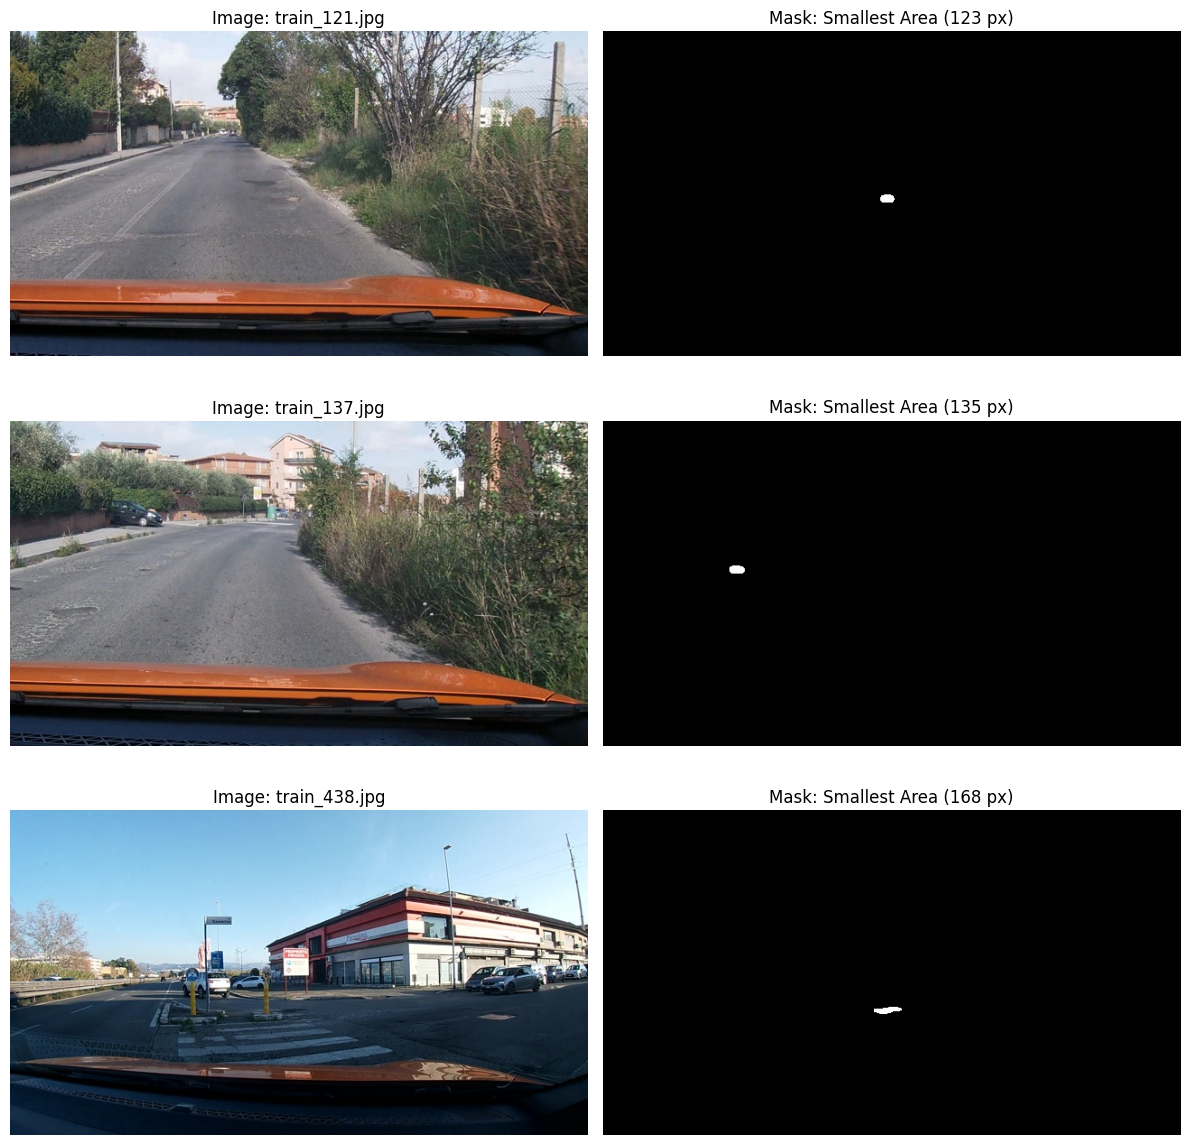

In [13]:
# ==========================================
# 6. CEK KUALITAS MASK (QA) - REVISI
# ==========================================
def check_mask_quality(img_dir, mask_dir, num_samples=3):
    print("🕵️ Memulai Quality Assurance (QA) pada Mask...")
    
    mask_files = glob.glob(os.path.join(mask_dir, "*"))
    valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG')
    mask_files = [f for f in mask_files if f.endswith(valid_exts)]
    
    if len(mask_files) == 0:
        print("❌ Error: Tidak ada mask ditemukan.")
        return

    empty_masks = 0
    suspicious_masks = 0 
    problematic_samples = []
    
    # List untuk menyimpan semua coverage mask (untuk sorting nanti)
    # Format: (area, img_path, mask_path)
    all_mask_coverages = [] 
    
    print(f"📂 Memeriksa {len(mask_files)} mask satu per satu...")
    
    for mask_path in tqdm(mask_files):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        # Thresholding & Hitung Area
        mask = (mask > 127).astype(np.uint8)
        area = np.count_nonzero(mask) # Hitung jumlah pixel putih
        
        # Cari path gambar pasangannya
        img_name = os.path.basename(mask_path).replace("mask", "train").replace(".png", ".jpg").replace(".JPG", ".jpg")
        img_path = os.path.join(img_dir, img_name)
        
        # Simpan data coverage untuk semua mask yang tidak kosong
        if area > 0:
            all_mask_coverages.append((area, img_path, mask_path))

        # 1. Cek Empty Mask
        if area == 0:
            empty_masks += 1
            if len(problematic_samples) < num_samples:
                problematic_samples.append((img_path, mask_path, "Empty (Kosong)"))
            continue
            
        # 2. Cek Artifacts (Objek Super Kecil < 20 px)
        if area < 20: 
            suspicious_masks += 1
            if len(problematic_samples) < num_samples:
                problematic_samples.append((img_path, mask_path, f"Suspicious ({area} px)"))

    # --- LOGIKA BARU: TAMPILKAN TERKECIL JIKA BERSIH ---
    if len(problematic_samples) == 0 and len(all_mask_coverages) > 0:
        print("\n✅ Dataset Bersih! Tidak ditemukan mask kosong atau artifact.")
        print(f"   -> Menampilkan {num_samples} mask dengan coverage TERKECIL sebagai sampel...")
        
        # Urutkan berdasarkan area terkecil
        all_mask_coverages.sort(key=lambda x: x[0])
        
        # Ambil Top N terkecil
        top_smallest = all_mask_coverages[:num_samples]
        for area, i_p, m_p in top_smallest:
            problematic_samples.append((i_p, m_p, f"Smallest Area ({area} px)"))

    # Laporan Statistik
    total = len(mask_files)
    print("\n" + "="*40)
    print("📋 LAPORAN KUALITAS MASK")
    print("="*40)
    print(f"Total Mask         : {total}")
    print(f"Empty Masks (0 px) : {empty_masks} ({empty_masks/total*100:.1f}%)")
    print(f"Suspicious (<20 px): {suspicious_masks} ({suspicious_masks/total*100:.1f}%)")
    print("="*40)

    # Visualisasi
    if len(problematic_samples) > 0:
        print("\n👁️ VISUALISASI SAMPEL:")
        plt.figure(figsize=(12, 4 * len(problematic_samples)))
        
        for i, (img_p, mask_p, issue) in enumerate(problematic_samples):
            img = cv2.imread(img_p)
            mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
            
            if img is None: 
                # Coba cari tanpa replace ekstensi jika gagal
                img = np.zeros((512, 512, 3), dtype=np.uint8) 
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
            plt.subplot(len(problematic_samples), 2, 2*i + 1)
            plt.imshow(img)
            plt.title(f"Image: {os.path.basename(img_p)}")
            plt.axis('off')
            
            plt.subplot(len(problematic_samples), 2, 2*i + 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"Mask: {issue}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Jalankan Fungsi
check_mask_quality(CONFIG['TRAIN_IMG_DIR'], CONFIG['TRAIN_MASK_DIR'])

> Selain itu, diketahui pada data train tidak terdapat gambar empty mask dan tidak ada mask yang di bawah 20 px yang mungkin menjadi indikasi data anomali yang memaksa model untuk belajar dari gambar yang seharusnya memiliki objek tetapi labelnya kosong.

🕵️ Mencari sampel artifact untuk visualisasi overlay...
   Scanning ukuran mask... Selesai.
✅ Tidak ditemukan artifact super kecil (<50px).
   Menampilkan 3 sampel random biasa untuk pengecekan...


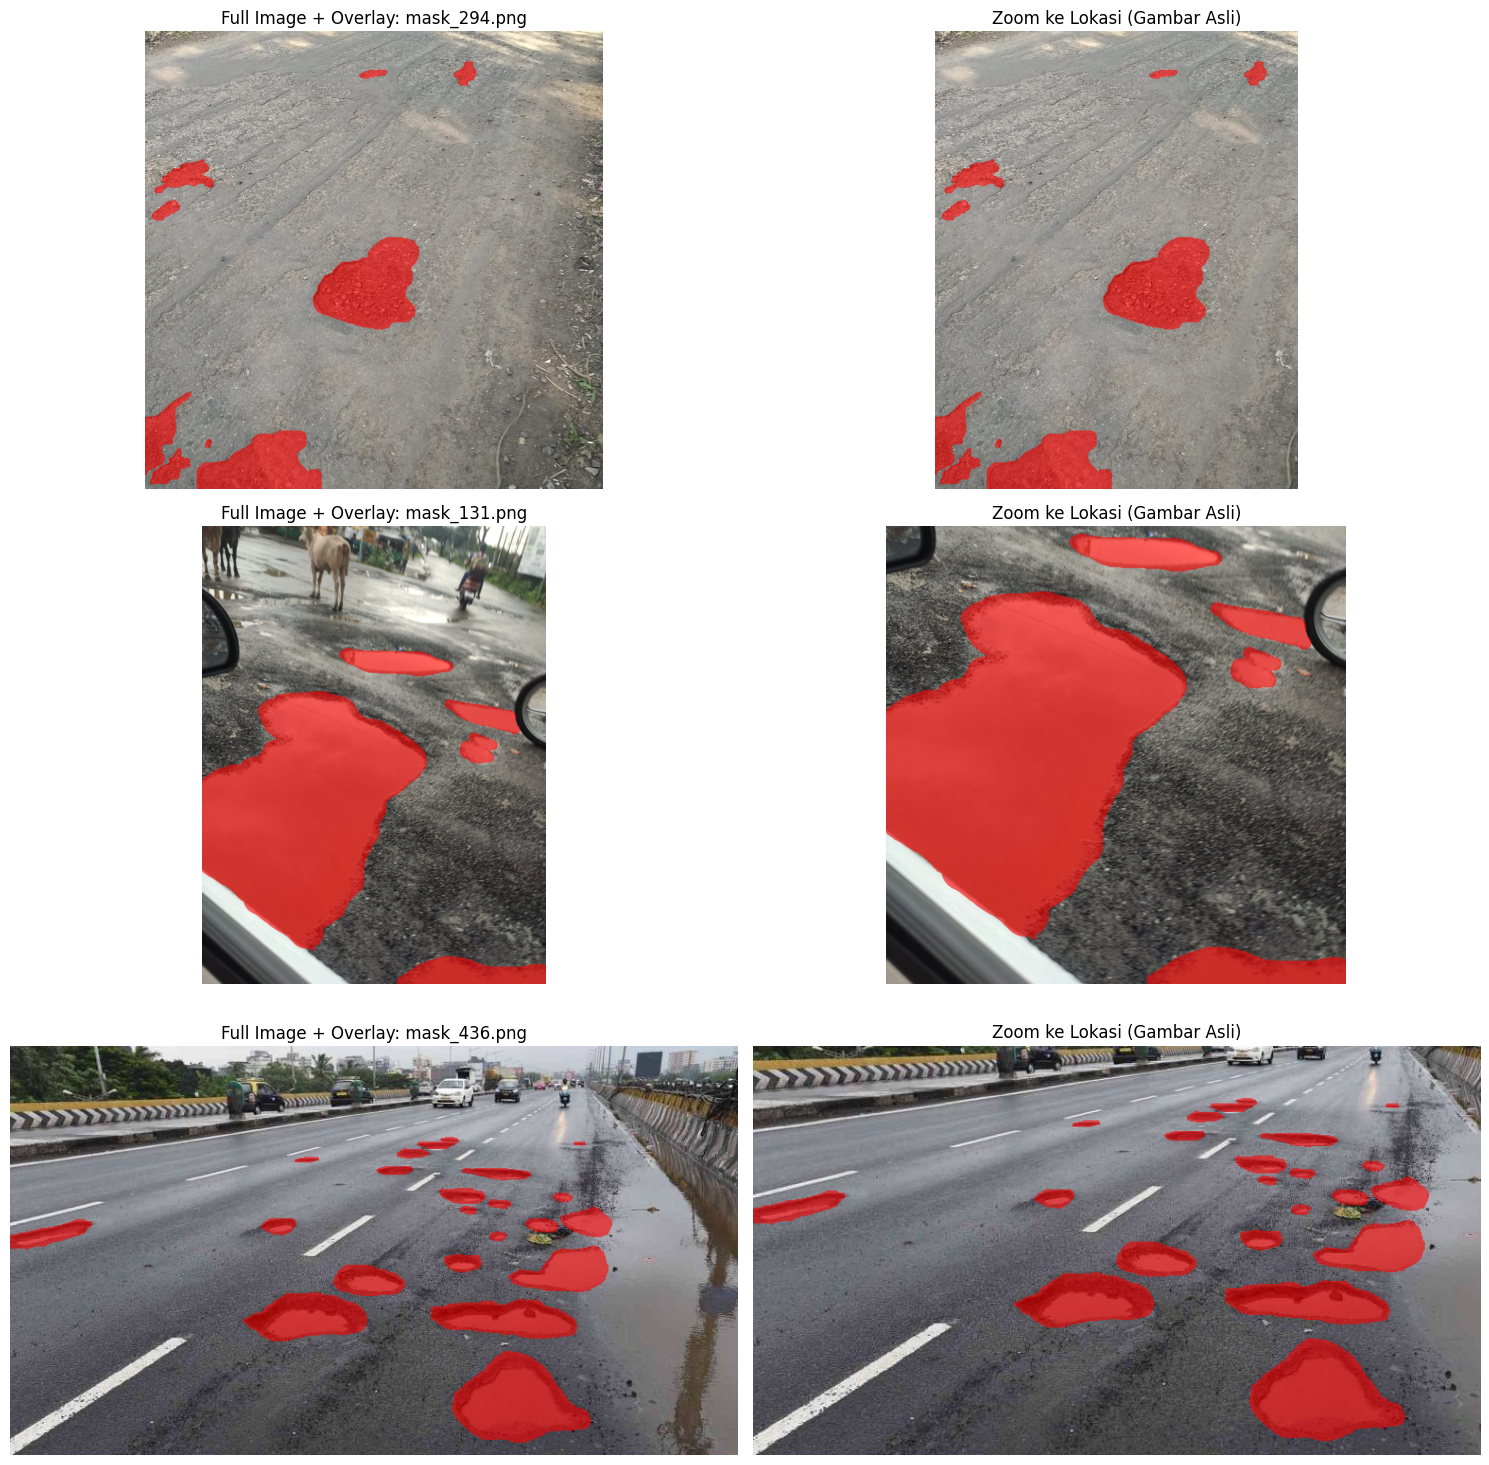

In [12]:
# ==========================================
# 7. VISUALISASI OVERLAY ARTIFACT
# ==========================================
def visualize_artifact_overlay(img_dir, mask_dir, num_samples=6):
    print("🕵️ Mencari sampel artifact untuk visualisasi overlay...")
    
    mask_files = glob.glob(os.path.join(mask_dir, "*"))
    # Filter hanya file gambar
    valid_exts = ('.png', '.jpg', '.jpeg')
    mask_files = [f for f in mask_files if f.endswith(valid_exts)]
    
    # 1. Cari Kandidat Artifact (Area < 50 pixel)
    # Kita cari yang kecil-kecil karena biasanya itu yang meragukan
    artifact_candidates = []
    
    print("   Scanning ukuran mask...", end="")
    for mask_path in mask_files: # Scan cepat
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        area = np.count_nonzero(mask > 127)
        
        # Kriteria Artifact: Ada isinya (bukan kosong), tapi sangat kecil (< 50 px)
        if 0 < area < 50:
            artifact_candidates.append(mask_path)
            
        # Limit pencarian agar tidak terlalu lama jika ketemu banyak
        if len(artifact_candidates) > 50:
            break
    print(" Selesai.")

    # 2. Pilih Sampel
    if len(artifact_candidates) > 0:
        print(f"⚠️ Ditemukan {len(artifact_candidates)} potensi artifact kecil.")
        print(f"   Menampilkan {num_samples} sampel acak...")
        # Pilih secara acak
        selected_files = random.sample(artifact_candidates, min(num_samples, len(artifact_candidates)))
    else:
        print("✅ Tidak ditemukan artifact super kecil (<50px).")
        print(f"   Menampilkan {num_samples} sampel random biasa untuk pengecekan...")
        selected_files = random.sample(mask_files, num_samples)

    # 3. Visualisasi Overlay
    plt.figure(figsize=(15, 5 * len(selected_files)))
    
    for i, mask_path in enumerate(selected_files):
        # Cari path gambar pasangannya
        mask_name = os.path.basename(mask_path)
        # Asumsi nama file sama, cuma beda folder/ekstensi
        # Sesuaikan replace ini dengan struktur nama file Anda (misal train_01.jpg vs mask_01.png)
        img_name_jpg = mask_name.replace("mask", "train").replace(".png", ".jpg").replace(".JPG", ".jpg")
        img_path = os.path.join(img_dir, img_name_jpg)
        
        # Baca File
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            # Coba cari tanpa replace 'mask' -> 'train' jika nama filenya sama persis
            img_path_alt = os.path.join(img_dir, mask_name.replace(".png", ".jpg"))
            image = cv2.imread(img_path_alt)
            
        if image is None:
            print(f"   Gagal load gambar untuk mask: {mask_name}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # --- PROSES OVERLAY ---
        # Buat mask berwarna merah
        mask_bool = mask > 127
        overlay = image.copy()
        
        # Warnai pixel lubang dengan Merah (R=255, G=0, B=0)
        overlay[mask_bool] = [255, 0, 0] 
        
        # Blend dengan gambar asli (Transparansi)
        alpha = 0.6 # Transparansi mask (0.0 - 1.0)
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
        
        # Crop Zoom ke area lubang (agar artifact terlihat jelas)
        # Cari bounding box lubang
        y_indices, x_indices = np.where(mask_bool)
        if len(y_indices) > 0:
            y_min, y_max = y_indices.min(), y_indices.max()
            x_min, x_max = x_indices.min(), x_indices.max()
            
            # Tambah padding biar enak dilihat
            pad = 50
            y_min = max(0, y_min - pad); y_max = min(image.shape[0], y_max + pad)
            x_min = max(0, x_min - pad); x_max = min(image.shape[1], x_max + pad)
            
            image_cropped = image[y_min:y_max, x_min:x_max]
        else:
            image_cropped = image # Jika mask kosong

        # Plotting
        plt.subplot(len(selected_files), 2, 2*i + 1)
        plt.imshow(image) # Gambar Full dengan Overlay Merah
        plt.title(f"Full Image + Overlay: {os.path.basename(mask_path)}")
        plt.axis('off')

        plt.subplot(len(selected_files), 2, 2*i + 2)
        plt.imshow(image_cropped) # Gambar Zoom (Tanpa Overlay biar kelihatan aslinya)
        plt.title("Zoom ke Lokasi (Gambar Asli)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan Fungsi
visualize_artifact_overlay(CONFIG['TRAIN_IMG_DIR'], CONFIG['TRAIN_MASK_DIR'], num_samples=3)

> Tidak ditemukan lubang dengan luas <50 px. Sehingga, dapat diasumsikan tidak ada noise lubang kecil dalam data train.

🔥 Sedang membuat Spatial Heatmap...
   Mengakumulasi 498 mask ke dalam satu heatmap...


  0%|          | 0/498 [00:00<?, ?it/s]

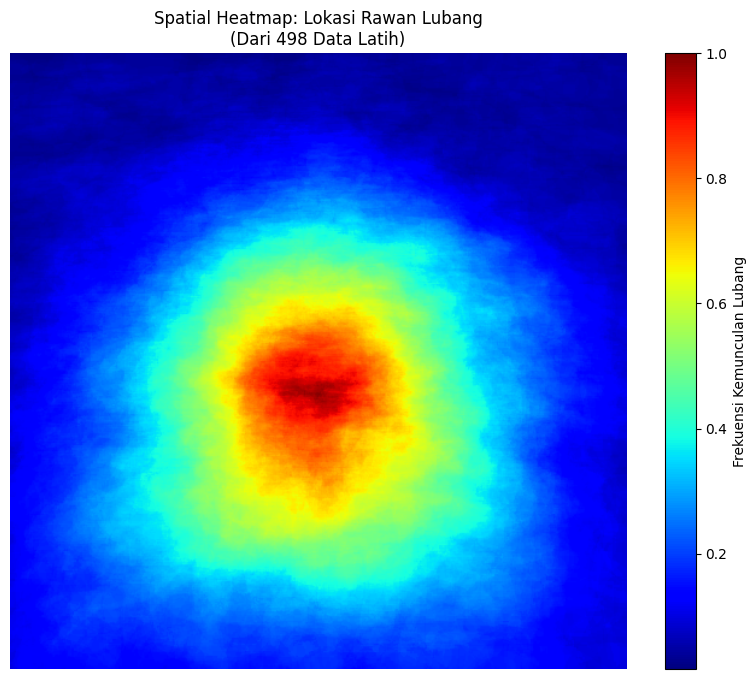


💡 CARA MEMBACA HEATMAP:
   🔴 Merah/Kuning: Area di mana lubang SANGAT SERING muncul.
   🔵 Biru: Area yang jarang ada lubang (biasanya langit/pepohonan).

📍 Hotspot Utama berada di koordinat: (x=256, y=283)
   -> Wajar. Lubang tersebar di TENGAH jalan.


In [14]:
# ==========================================
# 8. SPATIAL HEATMAP (LOKASI SERING MUNCUL)
# ==========================================
def visualize_spatial_heatmap(mask_dir, target_size=512):
    print("🔥 Sedang membuat Spatial Heatmap...")
    
    mask_files = glob.glob(os.path.join(mask_dir, "*"))
    valid_exts = ('.png', '.jpg', '.jpeg')
    mask_files = [f for f in mask_files if f.endswith(valid_exts)]
    
    if len(mask_files) == 0:
        print("❌ Error: Tidak ada mask ditemukan.")
        return

    # Inisialisasi kanvas kosong (Float agar bisa menampung penjumlahan)
    heatmap = np.zeros((target_size, target_size), dtype=np.float32)
    
    print(f"   Mengakumulasi {len(mask_files)} mask ke dalam satu heatmap...")
    
    for mask_path in tqdm(mask_files):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        # Resize ke ukuran standar agar bisa ditumpuk
        # Kita pakai INTER_NEAREST agar tetap tegas (0 atau 1)
        mask_resized = cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
        
        # Normalisasi ke 0 dan 1
        mask_bin = (mask_resized > 127).astype(np.float32)
        
        # Tambahkan ke heatmap
        heatmap += mask_bin

    # Normalisasi Heatmap agar range-nya 0.0 - 1.0 untuk visualisasi
    if heatmap.max() > 0:
        heatmap_norm = heatmap / heatmap.max()
    else:
        heatmap_norm = heatmap

    # Visualisasi
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_norm, cmap='jet', interpolation='bilinear')
    plt.colorbar(label='Frekuensi Kemunculan Lubang')
    plt.title(f"Spatial Heatmap: Lokasi Rawan Lubang\n(Dari {len(mask_files)} Data Latih)")
    plt.axis('off')
    plt.show()
    
    # --- INTERPRETASI OTOMATIS ---
    print("\n💡 CARA MEMBACA HEATMAP:")
    print("   🔴 Merah/Kuning: Area di mana lubang SANGAT SERING muncul.")
    print("   🔵 Biru: Area yang jarang ada lubang (biasanya langit/pepohonan).")
    
    # Cek Center of Mass (Pusat Massa)
    y_center, x_center = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    print(f"\n📍 Hotspot Utama berada di koordinat: (x={x_center}, y={y_center})")
    
    if y_center < target_size // 3:
        print("   -> Aneh! Hotspot ada di bagian ATAS gambar (Langit?). Cek mask Anda!")
    elif y_center > 2 * target_size // 3:
        print("   -> Wajar. Lubang sering muncul di bagian BAWAH (Dekat kamera mobil).")
    else:
        print("   -> Wajar. Lubang tersebar di TENGAH jalan.")

# Jalankan Fungsi
visualize_spatial_heatmap(CONFIG['TRAIN_MASK_DIR'], target_size=CONFIG['IMG_SIZE'])

> Visualisasi heatmap ini mengungkap fenomena yang dikenal sebagai "Center Bias" yang sangat kuat dalam data train. Area merah pekat yang terkonsentrasi di koordinat pusat (x=256, y=283) menunjukkan bahwa mayoritas data diambil dengan kamera yang sengaja dibidik tepat ke arah lubang, menyisakan area pinggir (zona biru) yang jarang memiliki fitur target. MIni berisiko model akan malas memprediksi lubang jika posisinya ada di pojok gambar.

# DATA PRE-PROCESSING

In [ ]:
# ==========================================
# 9. UTILS & DATASET
# ==========================================
def rle_encode(mask):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def calculate_dice(prob, target, threshold=0.5):
    if prob.shape != target.shape:
        prob = torch.sigmoid(prob)
    pred = (prob > threshold).float()
    target = target.float()
    smooth = 1e-6
    intersect = (pred * target).sum()
    dice = (2. * intersect + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

class PotholeDataset(Dataset):
    def __init__(self, image_ids, image_dir, mask_dir=None, transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mask_dir:
            mask_name = img_name.replace("train", "mask").replace(".jpg", ".png").replace(".JPG", ".png")
            mask_path = os.path.join(self.mask_dir, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                mask_path_jpg = os.path.join(self.mask_dir, img_name.replace("train", "mask"))
                mask = cv2.imread(mask_path_jpg, cv2.IMREAD_GRAYSCALE)
            
            mask = np.where(mask > 127, 1.0, 0.0) 
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            return image, mask.unsqueeze(0), img_name
        else:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, img_name



> Kode ini mengimplementasikan algoritma Run-Length Encoding (RLE), sebuah metode kompresi lossless yang mengubah representasi matriks biner (gambar mask) menjadi format string ringkas. Berdasarkan grafik "Sebaran Resolusi" yang memperlihatkan ada gambar dengan resolusi raksasa (hingga 4000+ px), mustahil memetakan tiap pikselnya satu-satu.
> 
>Lalu:
> 1. Menginstal Library tambahan dengan mengunduh paket segmentation-models-pytorch dan timm. 
> 2. Menentukan Standar Penilaian dengan membuat fungsi calculate_dice yang berfungsi untuk menghitung skor akurasi dengan melihat seberapa tepat tumpukan (irisan) antara tebakan model dengan kunci jawaban yang sebenarnya.
> 3. Dataset loading

In [ ]:
# ==========================================
# 10. TRANSFORMATIONS
# ==========================================
train_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomShadow(num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.5),
    A.CoarseDropout(max_holes=8, max_height=CONFIG['IMG_SIZE']//20, max_width=CONFIG['IMG_SIZE']//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 11. K-FOLD SPLIT PREPARATION
# ==========================================
all_image_files = sorted([f for f in os.listdir(CONFIG['TRAIN_IMG_DIR']) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
df_folds = pd.DataFrame({'image_id': all_image_files})
skf = StratifiedKFold(n_splits=CONFIG['N_FOLDS'], shuffle=True, random_state=42)

# Dummy labels for stratification
df_folds['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(df_folds, np.zeros(len(df_folds)))):
    df_folds.loc[val_idx, 'fold'] = fold

# Containers for OOF predictions
oof_manet = np.zeros((len(df_folds), CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.float32)
oof_unet = np.zeros((len(df_folds), CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.float32)
oof_segform = np.zeros((len(df_folds), CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.float32)
true_masks = np.zeros((len(df_folds), CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.float32)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_55/2957681430.py:9: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow(num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.5),
/tmp/ipykernel_55/2957681430.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=CONFIG['IMG_SIZE']//20, max_width=CONFIG['IMG_SIZE']//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.3),


> 1. A.Resize(CONFIG['IMG_SIZE'], ...)
Mengubah ukuran semua gambar input menjadi dimensi tetap (512x512) agar bisa diproses oleh GPU dalam batch.
Berdasarkan Scatter Plot Resolusi, dataset ini memiliki variasi resolusi yang sangat ekstrem (dari 300px hingga 4000px). Tanpa Resize, model tidak akan bisa memproses tensor dengan dimensi yang berubah-ubah. 

> 2. A.HorizontalFlip & A.ShiftScaleRotate
Dikarenakan terdapat Center Bias berdasarkan Spatial Heatmap di mana mayoritas lubang berkumpul di tengah (koordinat 256, 283), model memiliki risiko tinggi menjadi "malas" dan hanya menebak lubang di tengah gambar. Shift dan Rotate secara paksa memindahkan posisi lubang ke pinggir, pojok, atau area yang jarang muncul di data asli. Ini memaksa model belajar fitur visual lubang (tekstur retakan, kedalaman), bukan menghafal lokasi lubang. Sedangkan Scale membantu model mengenali lubang yang sama dalam berbagai ukuran, mengatasi ketimpangan distribusi ukuran lubang.

> 3. A.CLAHE (Contrast Limited Adaptive Histogram Equalization)
Analisis histogram menunjukkan kurva kecerahan yang menumpuk di area mid-tone (nilai ~134). Masalah utama deteksi lubang jalan adalah kemiripan warna di mana aspal itu abu-abu dan lubang juga abu-abu. CLAHE secara spesifik mengangkat detail pada area gelap yang diasumsikan sebagai lubang dan memisahkannya dari tekstur aspal di sekitarnya.

> 5. A.RandomShadow
Meskipun distribusi kecerahan Train dan Test mirip, histogram Test sedikit lebih runcing di area tertentu. Di dunia nyata, musuh utama visi komputer adalah bayangan pohon, gedung, atau tiang listrik yang bisa disalahartikan sebagai lubang. RandomShadow memaksa model membedakan "gelap karena lubang" dan "gelap karena bayangan".

> 5. A.CoarseDropout
Augmentasi ini menghapus bagian gambar secara acak dan peneliti mengisinya dengan warna hitam, sehingga model dipaksa melihat konteks global jalan raya untuk menyimpulkan keberadaan lubang, bukan hanya menghafal pola kecil yang spesifik.

> 6. val_transform (Hanya Resize & Normalize)
Data validasi dan test dilarang tersentuh oleh augmentasi acak seperti rotasi atau dropout. Tujuannya adalah mengukur performa model pada data "murni" apa adanya.

> Kode persiapan K-Fold Cross-Validation dan inisialisasi Out-of-Fold (OOF) ini berfungsi sebagai mekanisme validasi yang objektif dengan membagi dataset menjadi beberapa fold agar setiap gambar mendapatkan giliran menjadi data uji. Pendekatan ini sangat krusial karena berdasarkan EDA, di mana dataset memiliki variasi ukuran lubang yang ekstrem dan bias posisi yang terpusat di tengah. Split data biasa berisiko menciptakan data validasi yang tidak representatif, sehingga memberikan skor performa semu. Selain itu, wadah OOF (oof_manet, dll.) memungkinkan untuk menyimpan prediksi "bersih" dari seluruh dataset untuk menghitung bobot ensemble yang presisi tanpa kebocoran data (data leakage), memastikan model benar-benar robust terhadap segala variasi ukuran dan posisi lubang di jalan raya.

# TRAINING PROCESS AND MODELLING

In [ ]:
# ==========================================
# 11. TRAINING LOOP (5-FOLD) - ANTI NaN VERSION
# ==========================================

import torch.nn as nn

for fold in range(CONFIG['N_FOLDS']):
    print(f"\n{'='*30}")
    print(f"       STARTING FOLD {fold}")
    print(f"{'='*30}")
    
    # --- Split Data ---
    train_ids = df_folds[df_folds['fold'] != fold]['image_id'].values
    val_ids = df_folds[df_folds['fold'] == fold]['image_id'].values
    val_idx_global = df_folds[df_folds['fold'] == fold].index.values

    train_ds = PotholeDataset(train_ids, CONFIG['TRAIN_IMG_DIR'], CONFIG['TRAIN_MASK_DIR'], transform=train_transform)
    val_ds = PotholeDataset(val_ids, CONFIG['TRAIN_IMG_DIR'], CONFIG['TRAIN_MASK_DIR'], transform=val_transform)
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

    # --- PERBAIKAN 1: Menambahkan smooth=1.0 ---
    # smooth=1.0 mencegah pembagian dengan nol (NaN) saat prediksi/mask kosong
    loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True, smooth=1.0)
    
    scaler = torch.amp.GradScaler('cuda')

    # ============================
    # --- MODEL 1: UNET CONVNEXT ---
    # ============================
    print(f"\n[Training UNet ConvNext - Fold {fold}]")
    model_u = smp.Unet(encoder_name="tu-convnext_base", encoder_weights="imagenet", in_channels=3, classes=1).to(CONFIG['DEVICE'])
    optimizer_u = torch.optim.AdamW(model_u.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
    
    for epoch in range(CONFIG['EPOCHS']):
        model_u.train()
        running_loss = 0.0
        running_dice = 0.0
        
        for images, masks, _ in train_loader:
            images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
            optimizer_u.zero_grad()
            
            with torch.amp.autocast('cuda'):
                outputs = model_u(images)
                loss = loss_fn(outputs, masks)
            
            # --- UPDATE STEP DENGAN CLIPPING ---
            scaler.scale(loss).backward()
            
            scaler.unscale_(optimizer_u) 
            nn.utils.clip_grad_norm_(model_u.parameters(), max_norm=2.0)
            
            scaler.step(optimizer_u)
            scaler.update()
            # -----------------------------------
            
            running_loss += loss.item()
            running_dice += calculate_dice(torch.sigmoid(outputs), masks)
        
        avg_loss = running_loss / len(train_loader)
        avg_dice = running_dice / len(train_loader)
        curr_lr = optimizer_u.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS']}] - Loss: {avg_loss:.4f} - Dice: {avg_dice:.4f} - LR: {curr_lr:.6f}")
    
    torch.save(model_u.state_dict(), f"unet_fold{fold}.pth")

    # ============================
    # --- MODEL 2: MANET ---
    # ============================
    print(f"\n[Training MAnet - Fold {fold}]")
    model_m = smp.MAnet(encoder_name="tu-convnext_base", encoder_weights="imagenet", in_channels=3, classes=1).to(CONFIG['DEVICE'])
    
    # --- PERBAIKAN 2: Mengurangi Weight Decay ---
    # Mengubah weight_decay dari 0.05 menjadi 1e-4 agar training lebih stabil
    optimizer_m = torch.optim.AdamW(model_m.parameters(), lr=CONFIG['LEARNING_RATE_MANET'], weight_decay=1e-4)
    
    for epoch in range(CONFIG['EPOCHS_MANET']):
        model_m.train()
        running_loss = 0.0
        running_dice = 0.0
        
        for images, masks, _ in train_loader:
            images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
            optimizer_m.zero_grad()
            
            with torch.amp.autocast('cuda'):
                outputs = model_m(images)
                loss = loss_fn(outputs, masks)
            
            # --- UPDATE STEP DENGAN CLIPPING ---
            scaler.scale(loss).backward()
            
            scaler.unscale_(optimizer_m)
            nn.utils.clip_grad_norm_(model_m.parameters(), max_norm=2.0)
            
            scaler.step(optimizer_m)
            scaler.update()
            # -----------------------------------
            
            running_loss += loss.item()
            running_dice += calculate_dice(torch.sigmoid(outputs), masks)

        avg_loss = running_loss / len(train_loader)
        avg_dice = running_dice / len(train_loader)
        curr_lr = optimizer_m.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS_MANET']}] - Loss: {avg_loss:.4f} - Dice: {avg_dice:.4f} - LR: {curr_lr:.6f}")
        
    torch.save(model_m.state_dict(), f"manet_fold{fold}.pth")

    # ============================
    # --- MODEL 3: SEGFORMER ---
    # ============================
    print(f"\n[Training Segformer - Fold {fold}]")
    model_s = smp.Segformer(encoder_name="mit_b3", encoder_weights="imagenet", in_channels=3, classes=1).to(CONFIG['DEVICE'])
    optimizer_s = torch.optim.AdamW(model_s.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=0.01)

    for epoch in range(CONFIG['EPOCHS']):
        model_s.train()
        running_loss = 0.0
        running_dice = 0.0
        
        for images, masks, _ in train_loader:
            images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
            optimizer_s.zero_grad()
            
            with torch.amp.autocast('cuda'):
                outputs = model_s(images)
                loss = loss_fn(outputs, masks)
            
            # --- UPDATE STEP DENGAN CLIPPING ---
            scaler.scale(loss).backward()
            
            scaler.unscale_(optimizer_s) 
            nn.utils.clip_grad_norm_(model_s.parameters(), max_norm=1.0) 
            
            scaler.step(optimizer_s)
            scaler.update()
            # -----------------------------------
            
            running_loss += loss.item()
            running_dice += calculate_dice(torch.sigmoid(outputs), masks)

        avg_loss = running_loss / len(train_loader)
        avg_dice = running_dice / len(train_loader)
        curr_lr = optimizer_s.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS']}] - Loss: {avg_loss:.4f} - Dice: {avg_dice:.4f} - LR: {curr_lr:.6f}")

    torch.save(model_s.state_dict(), f"segformer_fold{fold}.pth")

    # ============================
    # --- GENERATE OOF PREDICTIONS ---
    # ============================
    print(f"\nGenerating OOF Predictions for Fold {fold}...")
    
    del optimizer_u, optimizer_m, optimizer_s
    torch.cuda.empty_cache()

    model_u.eval(); model_m.eval(); model_s.eval()
    
    with torch.no_grad():
        for i, (images, masks, _) in enumerate(val_loader):
            images = images.to(CONFIG['DEVICE'])
            
            start_idx = i * CONFIG['BATCH_SIZE']
            curr_batch_size = images.size(0)
            batch_indices = val_idx_global[start_idx : start_idx + curr_batch_size]

            p_u = torch.sigmoid(model_u(images)).cpu().numpy().squeeze()
            p_m = torch.sigmoid(model_m(images)).cpu().numpy().squeeze()
            p_s = torch.sigmoid(model_s(images)).cpu().numpy().squeeze()
            
            oof_unet[batch_indices] = p_u
            oof_manet[batch_indices] = p_m
            oof_segform[batch_indices] = p_s
            true_masks[batch_indices] = masks.squeeze().numpy()


       STARTING FOLD 0

[Training UNet ConvNext - Fold 0]


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch [1/20] - Loss: 0.6832 - Dice: 0.4477 - LR: 0.000100
Epoch [2/20] - Loss: 0.5303 - Dice: 0.6565 - LR: 0.000100
Epoch [3/20] - Loss: 0.4542 - Dice: 0.7524 - LR: 0.000100
Epoch [4/20] - Loss: 0.3933 - Dice: 0.8025 - LR: 0.000100
Epoch [5/20] - Loss: 0.3430 - Dice: 0.8295 - LR: 0.000100
Epoch [6/20] - Loss: 0.3042 - Dice: 0.8417 - LR: 0.000100
Epoch [7/20] - Loss: 0.2575 - Dice: 0.8721 - LR: 0.000100
Epoch [8/20] - Loss: 0.2423 - Dice: 0.8749 - LR: 0.000100
Epoch [9/20] - Loss: 0.2046 - Dice: 0.8936 - LR: 0.000100
Epoch [10/20] - Loss: 0.1824 - Dice: 0.9035 - LR: 0.000100
Epoch [11/20] - Loss: 0.1683 - Dice: 0.9078 - LR: 0.000100
Epoch [12/20] - Loss: 0.1533 - Dice: 0.9084 - LR: 0.000100
Epoch [13/20] - Loss: 0.1432 - Dice: 0.9120 - LR: 0.000100
Epoch [14/20] - Loss: 0.1341 - Dice: 0.9160 - LR: 0.000100
Epoch [15/20] - Loss: 0.1220 - Dice: 0.9222 - LR: 0.000100
Epoch [16/20] - Loss: 0.1111 - Dice: 0.9272 - LR: 0.000100
Epoch [17/20] - Loss: 0.1148 - Dice: 0.9198 - LR: 0.000100
Epoch 

config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

Epoch [1/20] - Loss: 0.5151 - Dice: 0.5303 - LR: 0.000100
Epoch [2/20] - Loss: 0.3401 - Dice: 0.7083 - LR: 0.000100
Epoch [3/20] - Loss: 0.2897 - Dice: 0.7448 - LR: 0.000100
Epoch [4/20] - Loss: 0.2455 - Dice: 0.7804 - LR: 0.000100
Epoch [5/20] - Loss: 0.2201 - Dice: 0.8032 - LR: 0.000100
Epoch [6/20] - Loss: 0.1897 - Dice: 0.8274 - LR: 0.000100
Epoch [7/20] - Loss: 0.1722 - Dice: 0.8425 - LR: 0.000100
Epoch [8/20] - Loss: 0.1760 - Dice: 0.8357 - LR: 0.000100
Epoch [9/20] - Loss: 0.1585 - Dice: 0.8514 - LR: 0.000100
Epoch [10/20] - Loss: 0.1401 - Dice: 0.8687 - LR: 0.000100
Epoch [11/20] - Loss: 0.1427 - Dice: 0.8654 - LR: 0.000100
Epoch [12/20] - Loss: 0.1339 - Dice: 0.8729 - LR: 0.000100
Epoch [13/20] - Loss: 0.1220 - Dice: 0.8847 - LR: 0.000100
Epoch [14/20] - Loss: 0.1267 - Dice: 0.8788 - LR: 0.000100
Epoch [15/20] - Loss: 0.1147 - Dice: 0.8903 - LR: 0.000100
Epoch [16/20] - Loss: 0.1100 - Dice: 0.8946 - LR: 0.000100
Epoch [17/20] - Loss: 0.1015 - Dice: 0.9027 - LR: 0.000100
Epoch 

> 1. U-Net + ConvNeXt Base
Ini adalah model baseline yang menggabungkan arsitektur klasik dengan encoder modern (ConvNeXt).
Kode ini berfokus untuk menggunakan teknik Gradient Accumulation (ACCUMULATION_STEPS = 4) dan Mixed Precision (torch.amp).
Tujuannya: Menghemat VRAM agar bisa melatih model yang cukup besar di GPU terbatas tanpa mengorbankan kualitas. 

> 2. (MAnet + ConvNeXt Base)
Kode ini mengganti arsitektur menjadi MAnet (Multi-scale Attention Net) dengan encoder yang sama.
Kode ini berfokus pada MAnet yang memiliki mekanisme "Attention" di bagian decoder-nya, yang membantu model lebih fokus membedakan fitur lubang jalan dari background yang mirip.
Perbedaan: Weight decay diset lebih tinggi (0.05) untuk mencegah overfitting karena MAnet sedikit lebih kompleks daripada U-Net biasa.

> 3. MSegFormer + MiT-B3
Ini adalah model berbasis Transformer, bukan CNN murni seperti dua model sebelumnya.
Kode ini berfokus dalam menggunakan arsitektur SegFormer dengan encoder MiT-B3. Transformer sangat bagus melihat "konteks global" (hubungan antar bagian gambar yang berjauhan).
Perbedaan: Ada penambahan Gradient Clipping (clip_grad_norm_). Ini wajib untuk Transformer karena gradiennya sering melonjak (tidak stabil) saat training. Hal ini untuk mencegah nilai loss bisa tiba-tiba jadi NaN.


> Pelatihan ketiga model tersebut dilakukan untuk membangun model Ensemble.
> 1. U-Net untuk struktur spasial yang kuat.
> 2. MAnet untuk fokus pada detail fitur yang sulit.
> 3. SegFormer untuk memahami konteks gambar secara keseluruhan.

> Prediksi ketiganya akan digabungkan dengan tujuan menghasilkan skor yang jauh lebih tinggi daripada satu model saja.

In [ ]:
# ==========================================
# 12. ISOTONIC CALIBRATION
# ==========================================


print("\n--- Fitting Isotonic Calibrators ---")
y_true_flat = true_masks.flatten()

iso_u = IsotonicRegression(out_of_bounds='clip').fit(oof_unet.flatten(), y_true_flat)
iso_m = IsotonicRegression(out_of_bounds='clip').fit(oof_manet.flatten(), y_true_flat)
iso_s = IsotonicRegression(out_of_bounds='clip').fit(oof_segform.flatten(), y_true_flat)




--- Fitting Isotonic Calibrators ---


> Melakukan Kalibrasi Probabilitas agar hasil prediksi model lebih "jujur":
> 1. Masalah: Model sering terlalu percaya diri (misal: yakin 90%, padahal aslinya peluang benarnya cuma 70%).
> 2. Solusi: Menggunakan Isotonic Regression untuk memperbaiki skor tersebut berdasarkan data validasi (OOF).
> 3. Tujuan: Menyamakan standar "keyakinan" antara U-Net, MAnet, dan SegFormer.
> 4. Hasil: Saat ketiga model digabung (Ensemble), bobot ensemble (Weighted Average) akan bekerja jauh lebih efektif karena semua skor sudah dinormalisasi ke standar kenyataan yang sama.

In [ ]:
# ==========================================
# 13. OPTUNA WEIGHT TUNING
# ==========================================
def objective(trial):
    w_m = trial.suggest_float('w_manet', 0.1, 0.7)
    w_u = trial.suggest_float('w_unet', 0.1, 0.7)
    w_s = trial.suggest_float('w_segform', 0.05, 0.4)
    threshold = trial.suggest_float('threshold', 0.35, 0.6)
    
    total = w_m + w_u + w_s
    w_m, w_u, w_s = w_m/total, w_u/total, w_s/total
    
    # Terapkan kalibrasi ke OOF sebelum ensemble
    # (Hanya ambil sampel kecil jika memori penuh)
    idx = np.random.choice(len(y_true_flat), 1000000, replace=False)
    
    p_m_cal = iso_m.transform(oof_manet.flatten()[idx])
    p_u_cal = iso_u.transform(oof_unet.flatten()[idx])
    p_s_cal = iso_s.transform(oof_segform.flatten()[idx])
    
    final_p = (p_m_cal * w_m) + (p_u_cal * w_u) + (p_s_cal * w_s)
    preds = (final_p > threshold).astype(np.uint8)
    
    # Simple Dice for flattened arrays
    intersect = (preds * y_true_flat[idx]).sum()
    dice = (2. * intersect + 1e-6) / (preds.sum() + y_true_flat[idx].sum() + 1e-6)
    return dice

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2026-02-13 03:08:08,227] A new study created in memory with name: no-name-f246298c-a110-4ec1-8595-1c53f68bf5ea
[I 2026-02-13 03:08:14,873] Trial 0 finished with value: 0.829494784052661 and parameters: {'w_manet': 0.6697599137316876, 'w_unet': 0.35694754294627806, 'w_segform': 0.23130942602213417, 'threshold': 0.36004863391032954}. Best is trial 0 with value: 0.829494784052661.
[I 2026-02-13 03:08:21,496] Trial 1 finished with value: 0.8324967789329287 and parameters: {'w_manet': 0.29244608292963864, 'w_unet': 0.23051452987869317, 'w_segform': 0.2808779650175557, 'threshold': 0.5127671716112397}. Best is trial 1 with value: 0.8324967789329287.
[I 2026-02-13 03:08:28,072] Trial 2 finished with value: 0.8215007278985151 and parameters: {'w_manet': 0.4630380244188149, 'w_unet': 0.6557891064359098, 'w_segform': 0.11782184599908266, 'threshold': 0.5690503479003215}. Best is trial 1 with value: 0.8324967789329287.
[I 2026-02-13 03:08:34,765] Trial 3 finished with value: 0.8195303187915554

Best Params: {'w_manet': 0.5074281509287467, 'w_unet': 0.5179053935154376, 'w_segform': 0.2574335667012099, 'threshold': 0.4261215161203984}


Menggunakan pustaka Optuna untuk mengotomatisasi pencarian kombinasi bobot ensemble (w manet,w unet,w segform) dan nilai threshold keputusan yang paling optimal secara matematis, alih-alih menentukannya secara manual (trial-and-error). Hal ini dikarenakan dikhawatirkan setiap arsitektur model memiliki tingkat kepercayaan yang berbeda-beda. Optuna menyeimbangkan kontribusi ketiga model ini dengan presisi dan menemukan titik threshold yang paling efektif (seringkali bergeser dari standar 0.5) untuk memaksimalkan Dice Score, sambil menerapkan kalibrasi probabilitas (iso_.transform) agar penggabungan prediksi dari arsitektur yang berbeda (CNN vs Transformer) menjadi selaras secara statistik.

# BEST MODEL ENSEMBLE, PREDICTION PROCESS, AND SUBMISSION MAKING

In [ ]:
# ==========================================
# 14. FINAL INFERENCE (ENSEMBLE 5-FOLD + MULTI-SCALE TTA)
# ==========================================

test_files = sorted([f for f in os.listdir(CONFIG['TEST_IMG_DIR']) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_ds = PotholeDataset(test_files, CONFIG['TEST_IMG_DIR'], transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Load all 5 folds
models_u = [smp.Unet(encoder_name="tu-convnext_base", in_channels=3, classes=1).to(CONFIG['DEVICE']) for _ in range(5)]
models_m = [smp.MAnet(encoder_name="tu-convnext_base", in_channels=3, classes=1).to(CONFIG['DEVICE']) for _ in range(5)]
models_s = [smp.Segformer(encoder_name="mit_b3", in_channels=3, classes=1).to(CONFIG['DEVICE']) for _ in range(5)]

for f in range(5):
    models_u[f].load_state_dict(torch.load(f"unet_fold{f}.pth", map_location=CONFIG['DEVICE']))
    models_m[f].load_state_dict(torch.load(f"manet_fold{f}.pth", map_location=CONFIG['DEVICE']))
    models_s[f].load_state_dict(torch.load(f"segformer_fold{f}.pth", map_location=CONFIG['DEVICE']))
    models_u[f].eval(); models_m[f].eval(); models_s[f].eval()

# Config TTA
SCALES = [0.8, 1.0, 1.2]
w = best_params
total_w = w['w_manet'] + w['w_unet'] + w['w_segform']

submission_data = []
print(f"Mulai Inference pada {len(test_ds)} gambar...")

with torch.no_grad():
    for images, img_name in test_loader:
        images = images.to(CONFIG['DEVICE'])
        tta_preds = []
        
        # 1. Loop Multi-Scale
        for scale in SCALES:
            if scale != 1.0:
                s_size = (int(CONFIG['IMG_SIZE'] * scale) // 32) * 32
                aug_img_scaled = torch.nn.functional.interpolate(images, size=(s_size, s_size), mode='bilinear', align_corners=False)
            else:
                aug_img_scaled = images
                s_size = CONFIG['IMG_SIZE']

            # 2. Loop Flip (None, Horizontal, Vertical)
            # PyTorch: dim 3 = Width, dim 2 = Height
            for flip_dims, np_axis in [(None, None), ([3], 1), ([2], 0)]:
                aug_img = aug_img_scaled if flip_dims is None else torch.flip(aug_img_scaled, dims=flip_dims)
                
                # Predict Ensemble Folds
                with torch.amp.autocast('cuda'):
                    p_u = torch.stack([torch.sigmoid(m(aug_img)) for m in models_u]).mean(0).cpu().numpy().flatten()
                    p_m = torch.stack([torch.sigmoid(m(aug_img)) for m in models_m]).mean(0).cpu().numpy().flatten()
                    p_s = torch.stack([torch.sigmoid(m(aug_img)) for m in models_s]).mean(0).cpu().numpy().flatten()
                
                # Anti-NaN Safety
                p_u = np.nan_to_num(p_u, nan=0.0)
                p_m = np.nan_to_num(p_m, nan=0.0)
                p_s = np.nan_to_num(p_s, nan=0.0)

                # Kalibrasi (Input harus 1D)
                p_u_cal = iso_u.transform(p_u)
                p_m_cal = iso_m.transform(p_m)
                p_s_cal = iso_s.transform(p_s)
                
                # Weighted Ensemble
                combined = (p_m_cal * (w['w_manet']/total_w)) + \
                           (p_u_cal * (w['w_unet']/total_w)) + \
                           (p_s_cal * (w['w_segform']/total_w))
                
                # Reshape ke 2D sesuai s_size
                combined = combined.reshape(s_size, s_size)
                
                # Revert Flip (Unflip) menggunakan axis NumPy yang benar
                if np_axis is not None:
                    combined = np.flip(combined, axis=np_axis)
                
                # Revert Scale ke 512x512 agar bisa di-average
                if scale != 1.0:
                    combined = cv2.resize(combined, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), interpolation=cv2.INTER_LINEAR)
                
                tta_preds.append(combined)
            
        # Rata-rata semua TTA (3 scales * 3 flips = 9 preds per image)
        final_prob = np.mean(tta_preds, axis=0)
        
        # Resize ke Original Size Gambar
        orig_img = cv2.imread(os.path.join(CONFIG['TEST_IMG_DIR'], img_name[0]))
        h_orig, w_orig = orig_img.shape[:2]
        final_mask = (cv2.resize(final_prob, (w_orig, h_orig)) > best_params['threshold']).astype(np.uint8)
        
        submission_data.append([img_name[0], rle_encode(final_mask)])

# Save result
df_sub = pd.DataFrame(submission_data, columns=['ImageId', 'rle'])
df_sub.to_csv('submission.csv', index=False)
print(f"Selesai! Berhasil mendeteksi pothole pada {df_sub[df_sub['rle'] != ''].shape[0]} gambar.")

Mulai Inference pada 295 gambar...


> Final Inference (Prediksi Akhir):

> 1. Ensemble model
Menggabungkan 3 model dan juga menggunakan 5-Fold Cross Validation untuk setiap tipe model (U-Net, MAnet, SegFormer).
Total ada 3 tipe x 5 fold = 15 model yang aktif memprediksi satu gambar. Ini membuat prediksi sangat stabil (robust).

> 2. Multi-Scale TTA (9 Variasi):
Menggunakan 3 Skala (0.8x, 1.0x, 1.2x).
Setiap skala dilakukan 3 jenis Flip (Original, Horizontal, Vertikal).
Total: 3 x 3 = 9 variasi prediksi per gambar.

> 3. Kalibrasi Probabilitas (Isotonic Regression):
Ada langkah iso.transform(p). Ini berarti sebelum digabung, probabilitas mentah dari model "dikalibrasi" dulu agar angkanya lebih jujur (misal: jika model bilang 70%, peluang benarnya benar-benar 70%).

> 4. Kombinasi Akhir:
Probabilitas dari 15 model × 9 variasi TTA digabung menggunakan bobot terbaik (w['w_manet'], dll).
Hasil rata-rata dikembalikan ke ukuran asli gambar dan dipotong dengan threshold terbaik untuk menjadi mask biner (0/1).